# Analysis of EM Algorithm for Hidden Units

This notebook analyses the results from the grid search over hidden cell fractions in the EM algorithm experiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100

In [2]:
# Path to grid search results
grid_search_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/hidden-units-em/grid-search"
)

# Find all run directories
run_dirs = sorted(
    [
        d
        for d in grid_search_dir.iterdir()
        if d.is_dir() and d.name.startswith("hidden-fraction-")
    ]
)
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 2 runs:
  hidden-fraction-0.10
  hidden-fraction-0.20


In [3]:
# Load final metrics from the last EM iteration for each run
def get_last_em_iteration(run_dir):
    """Find the last EM iteration directory."""
    em_dirs = sorted(
        [d for d in run_dir.iterdir() if d.is_dir() and d.name.startswith("em_iter_")]
    )
    return em_dirs[-1] if em_dirs else None


def load_em_metrics(run_dir):
    """Load metrics from all EM iterations for a run."""
    em_dirs = sorted(
        [d for d in run_dir.iterdir() if d.is_dir() and d.name.startswith("em_iter_")]
    )
    all_metrics = []

    for em_dir in em_dirs:
        metrics_path = em_dir / "training_metrics.csv"
        if metrics_path.exists():
            df = pd.read_csv(metrics_path)
            # Get final row of this EM iteration
            final_row = df.iloc[-1].to_dict()
            all_metrics.append(final_row)

    return pd.DataFrame(all_metrics)


# Load data for all runs
all_runs_data = {}
for run_dir in run_dirs:
    match = re.search(r"hidden-fraction-(\d+\.\d+)", run_dir.name)
    if match:
        hidden_frac = float(match.group(1))
        metrics_df = load_em_metrics(run_dir)
        if not metrics_df.empty:
            all_runs_data[hidden_frac] = metrics_df
            print(
                f"Loaded {len(metrics_df)} EM iterations for hidden_frac={hidden_frac}"
            )

Loaded 9 EM iterations for hidden_frac=0.1
Loaded 10 EM iterations for hidden_frac=0.2


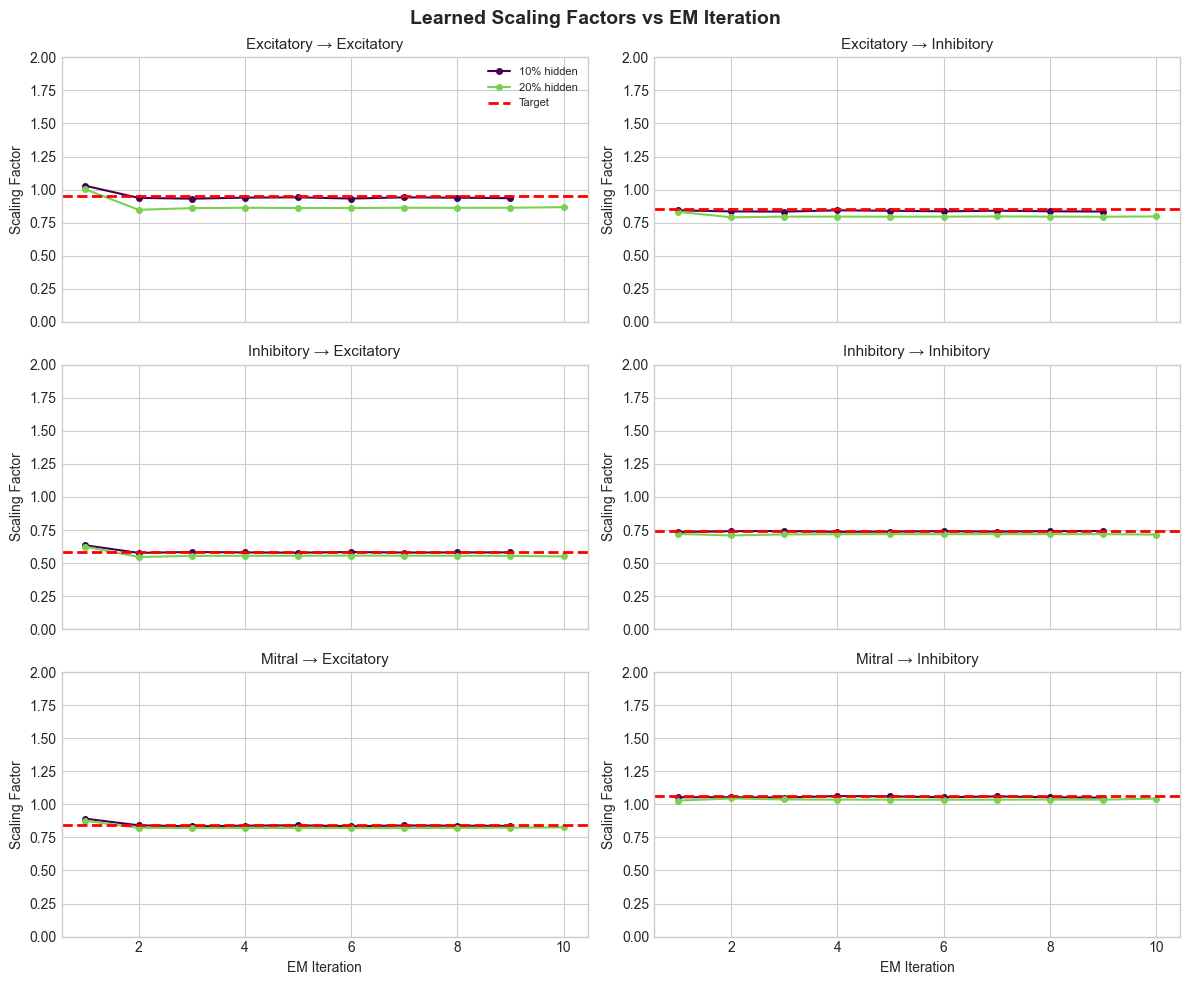

In [4]:
# Plot scaling factors vs EM iteration for each hidden fraction (3x2 subplot)
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ("excitatory_to_excitatory", "Excitatory \u2192 Excitatory"),
    ("excitatory_to_inhibitory", "Excitatory \u2192 Inhibitory"),
    ("inhibitory_to_excitatory", "Inhibitory \u2192 Excitatory"),
    ("inhibitory_to_inhibitory", "Inhibitory \u2192 Inhibitory"),
    ("mitral_to_excitatory", "Mitral \u2192 Excitatory"),
    ("mitral_to_inhibitory", "Mitral \u2192 Inhibitory"),
]

colors = plt.cm.viridis(np.linspace(0, 0.8, len(all_runs_data)))

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]

    for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
        em_iters = df["em/iteration"].values
        values = df[f"scaling_factors/{key}/value"].values
        ax.plot(
            em_iters,
            values,
            "o-",
            color=color,
            markersize=4,
            label=f"{hidden_frac:.0%} hidden",
        )

    # Plot target (from first run, should be same for all)
    first_df = list(all_runs_data.values())[0]
    target = first_df[f"scaling_factors/{key}/target"].iloc[0]
    ax.axhline(y=target, color="red", linestyle="--", linewidth=2, label="Target")

    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Scaling Factor")
    ax.set_ylim(0, 2)

    if idx >= 4:  # Bottom row
        ax.set_xlabel("EM Iteration")

    if idx == 0:
        ax.legend(loc="best", fontsize=8)

plt.suptitle("Learned Scaling Factors vs EM Iteration", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

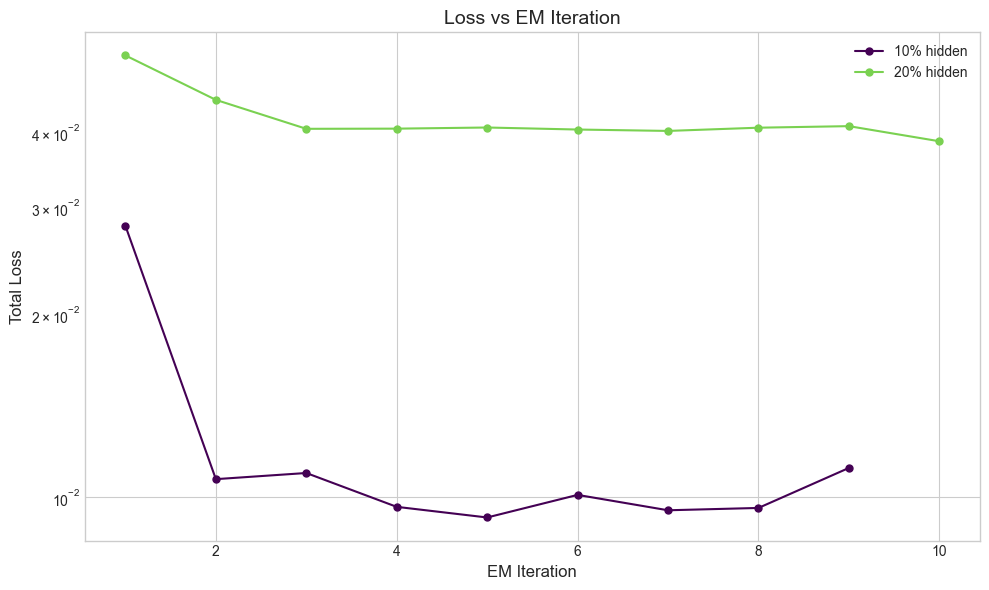

In [5]:
# Plot loss vs EM iteration for each hidden fraction
fig, ax = plt.subplots(figsize=(10, 6))

for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
    em_iters = df["em/iteration"].values
    loss = df["total_loss"].values
    ax.plot(
        em_iters,
        loss,
        "o-",
        color=color,
        markersize=5,
        label=f"{hidden_frac:.0%} hidden",
    )

ax.set_xlabel("EM Iteration", fontsize=12)
ax.set_ylabel("Total Loss", fontsize=12)
ax.set_title("Loss vs EM Iteration", fontsize=14)
ax.legend(loc="best")
ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
# Final firing rate vs hidden fraction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Collect final firing rates for each hidden fraction
final_firing_rates = []
for hidden_frac, df in sorted(all_runs_data.items()):
    final_row = df.iloc[-1]
    final_firing_rates.append(
        {
            "hidden_fraction": hidden_frac,
            "student_visible": final_row["firing_rate/student/visible/mean"],
            "student_hidden": final_row["firing_rate/student/hidden/mean"],
            "teacher_visible": final_row["firing_rate/teacher/visible/mean"],
            "teacher_hidden": final_row["firing_rate/teacher/hidden/mean"],
        }
    )

fr_df = pd.DataFrame(final_firing_rates)
hidden_fracs_pct = fr_df["hidden_fraction"] * 100

# Left: Visible neurons
ax = axes[0]
ax.plot(
    hidden_fracs_pct,
    fr_df["student_visible"],
    "o-",
    markersize=8,
    color="C0",
    label="Student",
)
ax.plot(
    hidden_fracs_pct,
    fr_df["teacher_visible"],
    "s--",
    markersize=8,
    color="red",
    label="Teacher",
)
ax.set_xlabel("Hidden Fraction (%)", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Visible Neurons: Final Firing Rate", fontsize=11)
ax.legend(loc="best")
ax.set_ylim(0, None)

# Right: Hidden neurons
ax = axes[1]
ax.plot(
    hidden_fracs_pct,
    fr_df["student_hidden"],
    "o-",
    markersize=8,
    color="C0",
    label="Student",
)
ax.plot(
    hidden_fracs_pct,
    fr_df["teacher_hidden"],
    "s--",
    markersize=8,
    color="red",
    label="Teacher",
)
ax.set_xlabel("Hidden Fraction (%)", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Hidden Neurons: Final Firing Rate", fontsize=11)
ax.legend(loc="best")
ax.set_ylim(0, None)

plt.suptitle("Final Firing Rate vs Hidden Fraction", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
# Summary: Final scaling factor error vs hidden fraction (with direction and std error)
final_results = []

for hidden_frac, df in sorted(all_runs_data.items()):
    final_row = df.iloc[-1]

    # Compute signed errors across all scaling factors
    errors = []
    for key, _ in scaling_factor_pairs:
        value = final_row[f"scaling_factors/{key}/value"]
        target = final_row[f"scaling_factors/{key}/target"]
        errors.append(value - target)  # Signed error (positive = overestimate)

    final_results.append(
        {
            "hidden_fraction": hidden_frac,
            "mean_error": np.mean(errors),
            "std_error": np.std(errors)
            / np.sqrt(len(errors)),  # Standard error of mean
            "final_loss": final_row["total_loss"],
        }
    )

final_df = pd.DataFrame(final_results)
hidden_fracs_pct = final_df["hidden_fraction"] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Scaling factor error with error bars
ax = axes[0]
ax.errorbar(
    hidden_fracs_pct,
    final_df["mean_error"],
    yerr=final_df["std_error"],
    fmt="o-",
    markersize=8,
    color="C0",
    capsize=5,
    capthick=2,
)
ax.axhline(y=0, color="red", linestyle="--", linewidth=2, label="Target (0 error)")
ax.set_xlabel("Hidden Fraction (%)", fontsize=12)
ax.set_ylabel("Mean Error (value - target)", fontsize=12)
ax.set_title("Scaling Factor Error vs Hidden Fraction", fontsize=11)
ax.legend(loc="best")

# Right: Final loss
ax = axes[1]
ax.plot(hidden_fracs_pct, final_df["final_loss"], "o-", markersize=8, color="C1")
ax.set_xlabel("Hidden Fraction (%)", fontsize=12)
ax.set_ylabel("Final Loss", fontsize=12)
ax.set_title("Final Loss vs Hidden Fraction", fontsize=11)

plt.suptitle(
    "Summary: Final Performance vs Hidden Fraction", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(final_df.to_string(index=False))